# LTA Overview  

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display


import pandas as pd 
import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import itertools
from matplotlib.lines import Line2D

from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import SphericalCircle

import re

In [2]:
### if using 'jupyter notebook' use: ###
%matplotlib notebook
### if using 'jupyter lab' use: ###
# %matplotlib inline   
# %matplotlib nbagg

## Roadmap

**Current version: 0**

Version 0 :
- [x] Split HBA LBA, project, debug mode: include verification checks
- [x] TBD: add A-team sources location on the skymap view; add warning for filtering out the WTG-verification-DMO
- [x] Add iteration over markers or colours for each prjoect

Version 1 (Friday 21/01/22):
- [x] Include exposures -filter in plot function for exposure range, default all 
- [ ] Fermi gamma ray map (can't find)
- [x] Circle for A-team and make optional
- [x] Clickable markers - proj, SASID, antenna, ant filter
- [ ] Make background optional
- [ ] add 2MASS and TGSS https://irsa.ipac.caltech.edu/Missions/2mass.html https://vo.astron.nl/tgssadr/q_fits/imgs/form
- [ ] implement on notebook

Version 2:
- [ ] 90% Time and smearing
- [ ] lb data sets (output) (low prio)
---
Other Notes:
- Reevaluate the usefulness of the to_keep list, is this not similar/or made redundant with the plotprojects specification of the plot_overview function ?
- Filtering unique ra and dec and antenna is temp, later will take into account 
- Will eventually run with Julich data (will require extra input param) and add if project/data is in both datbases

Notes from 12/01:
- clickable markers
- interactive!

---
Where I stopped/ to do (03/05):
- [ ] Need to debug the plotting for POZNAN
- [ ] Check that recent change to code ie correct number of saps and coords. also check with other subsheets eg avg pipeline 



## Functions

### Prep

In [3]:
def split_saps(x):
    if x['SAPS'] == np.nan:
        saps = range(0, len(x.RA))
        return [saps]
    else:
        return str(x['SAPS']).split(",")
#         print(type(x["SAPS"]))
#     try:
#         return x.split(",")
#     except AttributeError:
#         return None

def replace_decimal_sep(list_coords):
    '''
    Function to replace all odd (ie every other) commas in a string to a "."
    This changes a list of comma separated decimals to a more sane list of point separated decimals 
    '''
    #make sure there are no "," that could cause issues with this code (this is not a great way of doing it but works)
    list_coords = list_coords.replace('.', ',')
    
    ind_comma = [i.start() for i in re.finditer(',', list_coords)]
    s = list(list_coords)     
    for i, val in enumerate(ind_comma):
        if i % 2 ==0:
            s[val] = '.'
    return ''.join(s)

def df_prep(datafile, to_keep):
    """
    Get relevant info for a selected list of projects as a new dataframe.
    
    Parameters
    ----------
    datafile : str
        The filename of the input database (i.e. with standardazed header structure)
    to_keep : list
        The list of projects to be selected for plotting
    debug: bool, optional
        Print auxiliary info for verifications
    
    Returns
    -------
    result : dataframe
        Dataframe with the subset of info relevant for the selected projects
    """
    
    df_og = pd.read_csv(datafile, delimiter="\t", dtype ={'SAPS': str})
    df = df_og.copy()
#   df = df.drop(['SUCCESSOR_MOM_ID', 'SUCCESSOR_SAS_ID', 'SUCCESSOR_TYPE', 'STORAGE_MANAGER', 
#                           'SPACE_USED', 'Size dysco compr [TB]', 
#                           'Expected compression time if LBA per subband', 
#                           'Expected compression time if HBA per subband',
#                           'Expected compression time per dataset' ], axis = 1)
    if to_keep == 'all':
        to_keep = df["PROJECT"].unique()
        
    df = df[df["PROJECT"].isin(to_keep)]
        
    # A special case is represented by the project WTG-verification-DMO, for which main info is not available !
    if 'WTG-verification-DMO' in to_keep:
        print("WARNING project 'WTG-verification-DMO' is unavailable for plotting and has been automatically discarded from plots and dataframes.")
    df = df[df["PROJECT"] != 'WTG-verification-DMO']
    
    #convert SPACE_USED column to a value
    df['SPACE_USED'] = df.SPACE_USED.map(lambda x: float(x.replace(",", ".")))
    
    
    
    df = df.replace({'DEC': '0'}, '0,0')
    
    df["Int_Stations"] = df.NR_INT_STATIONS.apply(lambda x: True if x > 0 else False)
    df['SAPS'] = df.apply(lambda x: split_saps(x), axis = 1)
#     df['SAPS'] = df.SAPS.apply(lambda x: split_saps(x))

    
    #remove trailing commas
    df["RA"] = df.apply(lambda x: x.RA if x.RA[-1] != ',' else x.RA[:-1], axis = 1)
    df["DEC"] = df.apply(lambda x: x.DEC if x.DEC[-1] != ',' else x.DEC[:-1], axis = 1)
    
    #Deal with the delimiter issue
    df["nSAPS"] = df.SAPS.apply(lambda x: len(x))
    
    df["RA"] = df.apply(lambda x: replace_decimal_sep(x.RA) if x.nSAPS != 1 else x.RA.replace(",", "."), axis = 1 )
    df["DEC"] = df.apply(lambda x: replace_decimal_sep(x.DEC) if x.nSAPS != 1 else x.DEC.replace(",", "."), axis = 1 )
    
    #split observations with mulitple SAPS into list. Also need to deal with delimiter inconsistency ("," when alone, "." when in list of observations)
    df["RA"] = df.apply(lambda x: x.RA.split(',') if x.nSAPS != 1 else [x.RA.replace(",", ".")], axis = 1)
    df["DEC"] = df.apply(lambda x: x.DEC.split(',') if x.nSAPS != 1 else [x.DEC.replace(",", ".")], axis = 1)
   
    #remove weird extra 0s at the beginning of the RAs
    df["RA"] = df.apply(lambda x: x.RA if len(x.RA)==len(x.DEC) else x.RA[1:], axis = 1) 
    
    #correct the SAPS that have missmatched numbers of SAPS compared to coords
    # TO BE DONE: VERIFY THIS ASSUMPTION -> as of 03/05 this was removed as it was incorrect. This was allowing incorrect spliting of coords to be passed through. SAPS always seem correct.
#     df["SAPS"] = df.apply(lambda x: len(x.RA)*[np.nan] if x.SAPS == None else [i for i in range(len(x.RA))], axis = 1) 


    # only exploded ra and dec as that is what is needed now but will probably have to come back
    # to this later if new info is required

    df = df.explode(["RA", "DEC", "SAPS"])
    df = df.reset_index(drop = True)
    
    #Extra cleaning
    df.MIN_EXPOSURE = df.MIN_EXPOSURE.apply( lambda x: float(x.replace(",", ".")) if isinstance(x, str) else float(x))
    df.RA = df.RA.apply(lambda x: float(x))
    df.DEC = df.DEC.apply(lambda x: float(x))
    
    return df

### Image 

In [4]:
def overview_image(df, outname, plotProject = 'all', plotAntenna = 'both', background = "408MHz" , plotAteam = False, exp_range = [- np.inf, np.inf], legend_ncols = 2, testMode = False): 
    """
    Plotting routine for a selected list of projects.
    
    Parameters
    ----------
    datafile : str
        The filename of the input database (i.e. with standardazed header structure)
    outname : str
        The prefix name for the generated outputs, e.g. plots
    plotProject : str
        The filter to select a subset of projects
    plotAntenna : str
        The filter for selecting and plottinf data of a specific antenna field
    background : str
        The background to be plotted, default Haslam's 408MHz 
    plotAteam: bool, optional
        Plot the A team source circles with names, default False
    exp_range: list of ints, optional 
        first elemet is the minimum exposure in seconds and second is maximum exposure, default all exposures
    legend_ncols : int
        The number of columns for the layout of the legend box
    debug: bool, optional
        Print auxiliary info for verifications
    testMode : bool, optional
        Only limit the plotting to the first 100 datapoints
    
    Returns
    -------
    result : plots
        Return specified plot
    """
    empty_df = False
    # cleanup Antenna column 
    df["ANTENNA"] = df.apply(lambda x: x.ANTENNA_SET[:3], axis =1)
    
    #filter out duplicates in project, ra, dec and antenna
    df = df.drop_duplicates(subset = ["PROJECT", "RA", "DEC", "ANTENNA"])
    df = df[df["MIN_EXPOSURE"] < exp_range[1]]
    df = df[df["MIN_EXPOSURE"] > exp_range[0]]
    
    if len(df) == 0:
        print("WARNING: Nothing to plot! Either everything has been filtered out or invalid dataframe provided.")
        empty_df = True
    
    #warn user if WTG selected as this was filtered out in df_prep    
    if 'WTG-verification-DMO' in plotProject:
        print("WARNING: Project 'WTG-verification-DMO' is unavailable for plotting and has been automatically discarded from plots and dataframes.")
    
    #select only the projects that the user wants to plot creating new df "df_red"
    if plotProject == 'all':
        df_red = df
    else:
        #for 'all' keyword
        if isinstance(plotProject, str) and plotProject == 'all':
            plotProject = [plotProject]
            df_red = df[df["PROJECT"].isin(plotProject)]
            
        elif isinstance(plotProject, list):
            df_red = df[df["PROJECT"].isin(plotProject)]
        else:
            print("ERROR: Invalid plotProject input. Please use list of projects as strings or the 'all' keyword")
    
        if len(plotProject) != len(df_red["PROJECT"].unique()):
            print("!!! WARNING: Project list lengths differ, some projects may not be plotted. Please double check name and format. !!!")
            print(f"Length plotProject: {len(plotProject)}")
            print(f"Length of Projects to plot: {len(df_red['PROJECT'].unique())}")
            
    #image stuff 
    backDict = {
        "none": 'data/lambda_mollweide_haslam408_nofilt.fits', #used to generate the shape of the white background, not for plotting
        "408MHz": 'data/lambda_mollweide_haslam408_nofilt.fits',
        #2MASS
        #TGSS
    }
    image = backDict[background]

    hdu = fits.open(image)[1]
    wcs = WCS(hdu.header)

#     fig = plt.figure(figsize = (9, 6))
    fig = plt.figure()
    fig.set_facecolor('white')
    ax = fig.add_subplot(projection = wcs, frame_class=EllipticalFrame)
    
    if background != "none":
        ax.imshow(hdu.data, vmin = 9e3, vmax = 1.5e5, cmap = 'hot') 
    else:
        data_nan = np.empty(hdu.data.shape)
        data_nan[:] = np.nan 
        ax.imshow(data_nan, vmin = 9e3, vmax = 1.5e5, cmap = 'hot') #need to plot something white to preserve shape of plot (if not becomes more spherical)
    
    #hard code the A team sources in: [name, coords]
    A_team = [["Cas_A", "23h23m24s +58d48m54s"],
              ["Cyg_A", "19h59m28.3564s +40d44m02.096s"],
              ["Her_A", "16h51m08.024s +04d59m34.91s"],
              ["Tau_A", "05h34m31.94s +22d00m52.2s"],
              ["Ver_A", "12h30m49.4233s +12d23m28.043s"]]
    if plotAteam:
        if backDict[background] == None:
            colour = 'k'
        else:
            colour = 'w'
        for A_source in A_team:
            c = SkyCoord(A_source[1])
            pix = wcs.world_to_pixel(c.galactic)
#             ax.scatter(pix[0], pix[1], marker = '^', c = 'b', s = 20)
#             print(c.lon)
            sph = SphericalCircle((c.ra,c.dec), 4*u.deg, edgecolor = 'b', facecolor='none', linewidth = 1.5, transform= ax.get_transform('fk5'))
            ax.add_patch(sph)
            if A_source[0] == "Tau_A":
                ax.text(pix[0] - 280, pix[1] + 1, A_source[0], c = colour)
            else:
                ax.text(pix[0] + 50, pix[1] + 1, A_source[0], c = colour)

    if not empty_df:
        #testmode to use a reduced number of points
        if testMode:
            df_to_run = df_red.iloc[:100]
        else:
            df_to_run = df_red
        #plot the points with appropirate transform and append proj name to the atenna lists. Later will use to
        # specify what projects are what antennas and count amount of points plotted
        HBA_proj = []
        LBA_proj = []

        colours = itertools.cycle(get_cmap('tab20').colors)
        projs = df_to_run["PROJECT"].unique()

        output_click = widgets.Output() #allow output to be printed to output cell

        def onpick(event):
            with output_click: #use to use widgets 
                ind = event.ind
                label = int(event.artist.get_label())

                print('Point selected:')

                print(f'\t Project code: {df_to_run["PROJECT"].loc[label]}')
                print(f'\t SAS ID: {df_to_run["SAS_ID"].loc[label]}')
                print(f'\t SAP: {df_to_run["SAPS"].loc[label]}')
                print(f'\t Antenna set: {df_to_run["ANTENNA_SET"].loc[label]}')
                print(f'\t Int. Stations: {df_to_run["Int_Stations"].loc[label]}')
                if "OBSERVATION_TYPE" in df_to_run.columns:
                    print(f'\t Observation type: {df_to_run["OBSERVATION_TYPE"].loc[label]}')
                elif "PREDECESSOR_TYPE" in df_to_run.columns:
                    print(f'\t Observation type: {df_to_run["PREDECESSOR_TYPE"].loc[label]}')

                min_exp = df_to_run["MIN_EXPOSURE"].loc[label]
                max_exp = df_to_run["MAX_EXPOSURE"].loc[label]

                if min_exp == max_exp:
                    print(f'\t Exposure: {max_exp} s')
                else:
                    print(f'\t Max Exposure: {max_exp} s')
                    print(f'\t Min Exposure: {min_exp} s')

        df_to_run["marker"] = df_to_run.apply(lambda x: "D" if x.ANTENNA == 'HBA' else "o", axis = 1)
        df_to_run["coords"] = df_to_run.apply(lambda x: SkyCoord(float(x.RA), float(x.DEC), unit = u.deg, frame='icrs'), axis = 1)
        df_to_run["pix"] = df_to_run.apply(lambda x: wcs.world_to_pixel(x.coords.galactic), axis = 1)

        proj_colours = []
        for proj in projs:
          colour = next(colours)
          proj_colours.append([proj, colour])
          for index, row in df_to_run[df_to_run["PROJECT"] == proj].iterrows():

    #           #Plot only required antenna + append to list to know which antenna was used for label later (temporary: could maybe use df filtering?)
              if (row["ANTENNA"] == 'HBA') and ((plotAntenna == 'HBA') or (plotAntenna == 'both')):
                  HBA_proj.append(row["PROJECT"])
                  ax.scatter(row["pix"][0], row["pix"][1], marker = row["marker"], color = colour, s = 20, label = index, picker = True)

              elif (row["ANTENNA"] == 'LBA') and ((plotAntenna == 'LBA') or (plotAntenna == 'both')):
                  LBA_proj.append(row["PROJECT"])
                  ax.scatter(row["pix"][0], row["pix"][1], marker = row["marker"], color = colour, s = 20, label = index, picker = True)

        # shrink box by 20% to fit the legend outside the plot
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        #get and plot only the unique labels in the legend
        handles, labels = ax.get_legend_handles_labels()
        labels = df_to_run["PROJECT"].loc[map(int, labels)]
        unique = [l for i, l in enumerate(labels) if l not in labels[:i]]
        unique.sort(key = lambda x:x[1])

        total_numpoints = 0 #counter for number of plotted points
        #use a new list (unique2) to modify the legend labels
        unique2 = []

        for i in projs:
          numpoints = HBA_proj.count(i) + LBA_proj.count(i)
          total_numpoints += numpoints

          if (i in HBA_proj) and (i in LBA_proj):
              lst = f'{i} #{numpoints} (HBA & LBA)'
              marker = 'D'
          elif i in HBA_proj:
              lst = f'{i} #{numpoints} (HBA)'
              marker = 'D'
          elif i in LBA_proj:
              lst = f'{i} #{numpoints} (LBA)'
              marker = 'o'
          else:
              print(f'Error: {i}')

          for j in proj_colours:
              if j[0] == i:
                 c = j[1]
          handle = Line2D([0], [0], marker = marker, color = c,markerfacecolor = c, label = lst)
          unique2.append(handle)

        # Put a legend to the right of the current axis
    #     ax.legend(*zip(*unique2), loc='center left', bbox_to_anchor=(1.1, 0.5), ncol = legend_ncols)
        ax.legend(handles = unique2, loc='center left', bbox_to_anchor=(1.1, 0.5), ncol = legend_ncols)
    fig.canvas.mpl_connect('pick_event', onpick)
        
    fig.suptitle(f"{outname}", y = 0.9)
    plt.subplots_adjust(top = 0.8, right = 0.5)
    fig.savefig(f"outputs/{outname}.png", bbox_inches = 'tight')
    plt.show()
#     out = widgets.Output(layout={'border': '1px solid black'})
#     with out:
    if not empty_df:
        display(output_click) #display output of click 

### 2d Histogram

In [5]:
def plot_2dhist(df):
    image = 'data/lambda_mollweide_haslam408_nofilt.fits'
    hdu = fits.open(image)[1]
    wcs = WCS(hdu.header)

    df_to_run = df
    fig2 = plt.figure()
    fig2.set_facecolor('white')
    ax2 = fig2.add_subplot(projection = wcs, frame_class=EllipticalFrame)
    #     ax2.imshow(hdu.data, vmin = 9e3, vmax = 1.5e5, cmap = 'hot') 
    bin_number = 100
    lon_edges = np.linspace(0,360, bin_number + 1)
    lat_edges = np.linspace(-90, 90, bin_number + 1)
    hist, lon_e, lat_e = np.histogram2d(df_to_run['RA'], df_to_run['DEC'])
#     print( df_to_run['RA'].shape)
#     ax2.pcolor(lon_e[:-1], lat_e[:-1], hist.T, shading='auto')
#     ax2.imshow(hist.T)
#     print(hist.shape)
#     cbar = plt.colorbar(
#             plt.cm.ScalarMappable(
#                 norm=mpl.colors.Normalize(0, 1), cmap='hot'
#             )
#         )
#     cbar.set_label("Density Distribution")
    ax2.hist2d(df_to_run['RA'], df_to_run['DEC'], bins = 100)
    plt.show()

### Explore data 

In [6]:
def plot_space_used(df):
    df.hist(column = 'SPACE_USED', bins = 30)
    plt.xlabel('TB')
    plt.ylabel('Counts')

    plt.show()

In [15]:
def plot_pie(df, column, y = 'MAX_EXPOSURE'):
    df.groupby([column]).sum().plot(kind='pie', y=y, autopct='%1.0f%%')

# SARA

## Raw data

In [21]:
testMode = False

#cp from column G of summary sheet
to_keep_raw = 'WTG-verification-DMO','DDT001','DDT002','DDT1_002','DDT2_001','DDT3_003','DDT4_002','DDT4_003','LC0_003','LC0_009','LC0_012','LC0_015','LC0_017','LC0_020','LC0_024','LC0_028','LC0_032','LC0_039','LC0_041','LC1_036','LC1_038','LC2_006','LC2_036','LC3_004','LC3_012','LC4_010','LC4_016','LC6_018','LC8_033','LC9_002'

#run scripts
df_raw_sara = df_prep('data/SARA-raw_data.tsv', to_keep_raw)

WARNING project 'WTG-verification-DMO' is unavailable for plotting and has been automatically discarded from plots and dataframes.


### Plot overview image

<IPython.core.display.Javascript object>


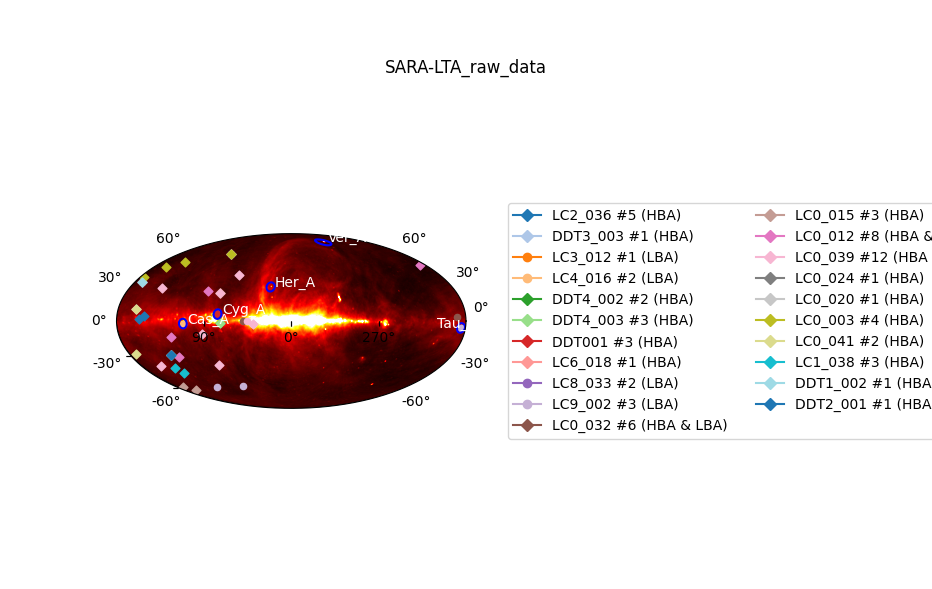

Output()

In [22]:
overview_image(df_raw_sara, 'SARA-LTA_raw_data',plotProject ='all',plotAntenna = 'both', testMode = testMode, plotAteam=True, exp_range = [-np.inf, 14000], background="408MHz")

<IPython.core.display.Javascript object>


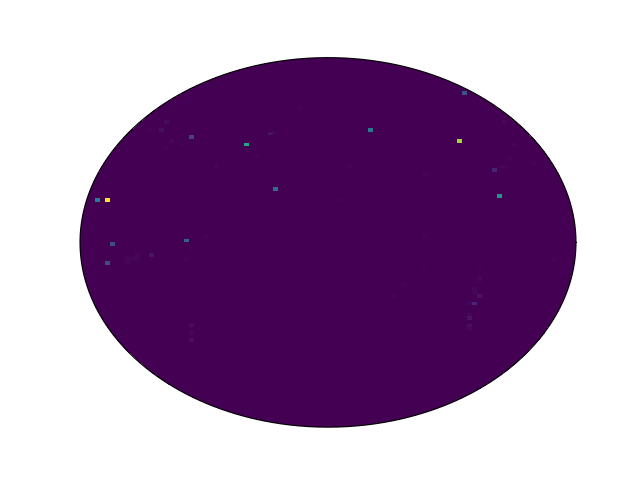

In [10]:
plot_2dhist(df_raw_sara)

### Example plots to explore data 

<IPython.core.display.Javascript object>


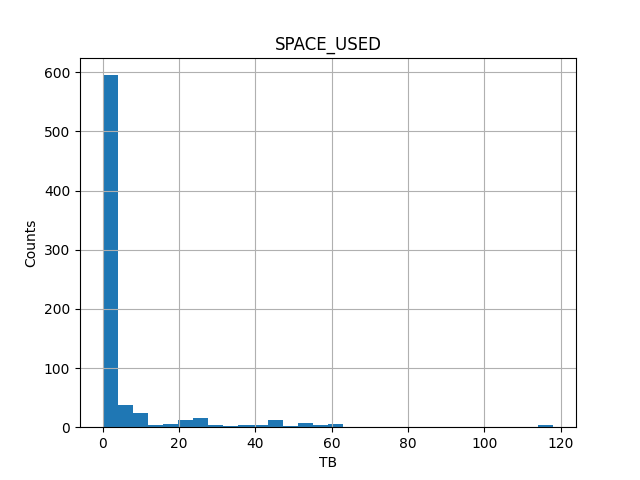

In [12]:
plot_space_used(df_raw_sara)

<IPython.core.display.Javascript object>


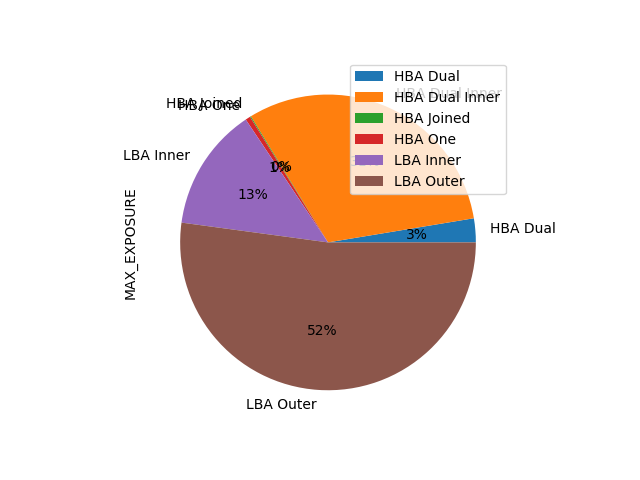

In [16]:
plot_pie(df_raw_sara, 'ANTENNA_SET')

<IPython.core.display.Javascript object>


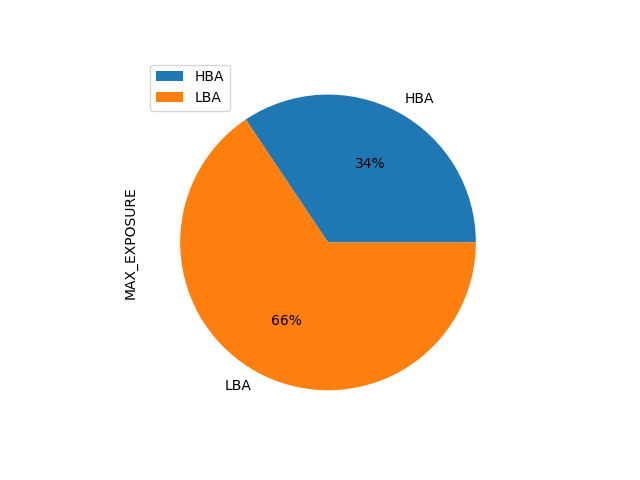

In [19]:
plot_pie(df_raw_sara, 'ANTENNA')

In [23]:
to_keep_avg_pip = 'DDT0007','DDT1_001','DDT1_002','DDT2_001','DDT3_003','DDT4_002','DDT4_003','DDT7_001','DDT9_001','DDT9_002','DDT9_005','DDT10_001','LC0_003','LC0_005','LC0_006','LC0_009','LC0_012','LC0_015','LC0_019','LC0_024','LC0_025','LC0_039','LC1_002','LC1_008','LC1_011','LC1_014','LC1_023','LC1_028','LC1_033','LC1_038','LC1_039','LC1_055','LC2_019','LC2_020','LC2_034','LC2_036','LC2_038','LC2_039','LC3_004','LC3_011','LC3_020','LC3_025','LC3_028','LC3_034','LC4_007','LC4_008','LC4_010','LC4_011','LC4_015','LC4_035','LC5_010','LC5_016','LC5_017','LC5_020','LC5_023','LC6_009','LC6_011','LC6_013','LC6_015','LC6_018','LC6_021','LC7_026','LC7_027','LC8_006','LC8_014','LC8_017','LC8_019','LC8_020','LC8_025','LC8_034','LC9_002','LC9_004','LC9_005','LC9_008','LC9_011','LC9_012','LC9_013','LC9_014','LC9_015','LC9_019','LC9_020','LC9_027','LC9_035','LC10_010','LC10_013','LC12_012','LT5_006','LT5_009','LT10_003','LT10_010','LT10_013'

df_avg_pip = df_prep('data/SARA-avg_pip_data_no_dysco.tsv', to_keep_avg_pip)
overview_image(df_avg_pip, 'SARA-LTA_avg_pip', legend_ncols = 5)

AttributeError: 'float' object has no attribute 'replace'

## cal pip data no dysco

In [29]:
to_keep_cal_pip = 'DDT0012','LC0_003','LC0_012','LC0_016','LC0_017','LC0_031','LC0_032','LC0_039','LC1_015','LC1_023','LC1_032','LC2_015','LC3_003','LC3_011','LC3_030','LC4_007','LC4_011','LC4_012','LC4_014','LC4_022','LC5_009','LC5_020','LC5_022','LC6_021','LT5_006'
df_cal_pip = df_prep('data/SARA-cal_pip_data_no_dysco.tsv', to_keep_cal_pip)
overview_image(df_cal_pip, 'SARA-LTA_cal_pip')

ValueError: could not convert string to float: '75E+000.3'

## lb avg pip data + lb pip data

Linked with cal pip SASIDS, will need to create df from cal_pip df

In [ ]:
to_keep_lb = 'LC4_007','LC4_014','LC5_020','LC5_022','LC6_021','LT5_006'

In [ ]:
ra_1 = 178.82
dec_1 = 26.48
ra_2 = 

# Juelich

<IPython.core.display.Javascript object>


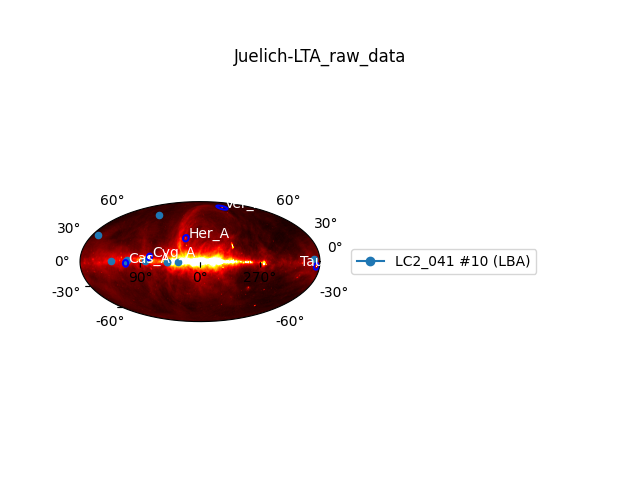

Output()

In [20]:
# to_keep_raw = 'WTG-verification-DMO','DDT001','DDT002','DDT1_002','DDT2_001','DDT3_003','DDT4_002','DDT4_003','LC0_003','LC0_009','LC0_012','LC0_015','LC0_017','LC0_020','LC0_024','LC0_028','LC0_032','LC0_039','LC0_041','LC1_036','LC1_038','LC2_006','LC2_036','LC3_004','LC3_012','LC4_010','LC4_016','LC6_018','LC8_033','LC9_002'
to_keep_raw = ['LC2_041']
#run scripts
df_raw = df_prep('data/IF-JULICH-raw_data.tsv', to_keep_raw)
overview_image(df_raw, outname = 'Juelich-LTA_raw_data',plotProject ='all',plotAntenna = 'both', testMode = testMode, plotAteam=True, exp_range = [-np.inf, 14000], background="408MHz")
# df_raw['MIN_EXPOSURE']

# Poznan

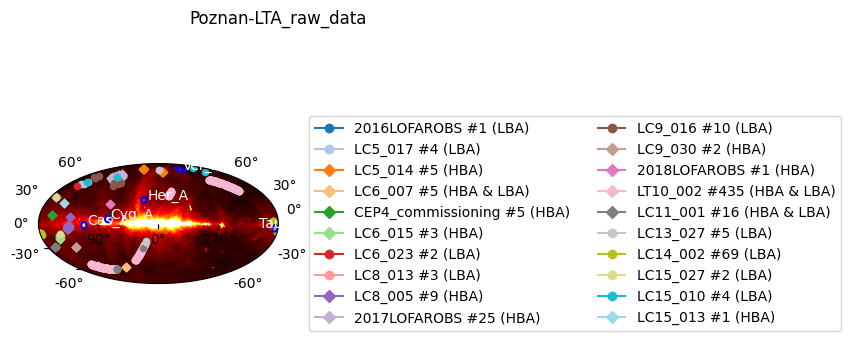

Output()

In [124]:
# to_keep_raw = 'WTG-verification-DMO','DDT001','DDT002','DDT1_002','DDT2_001','DDT3_003','DDT4_002','DDT4_003','LC0_003','LC0_009','LC0_012','LC0_015','LC0_017','LC0_020','LC0_024','LC0_028','LC0_032','LC0_039','LC0_041','LC1_036','LC1_038','LC2_006','LC2_036','LC3_004','LC3_012','LC4_010','LC4_016','LC6_018','LC8_033','LC9_002'
# to_keep_raw = ['LC5_017', 'CEP4_commissioning']
to_keep_raw = 'all'
testMode = False
#run scripts
df_raw = df_prep('data/IF-POZNAN-raw_data.tsv', to_keep_raw)
# df_raw
# df_raw['MIN_EXPOSURE']
overview_image(df_raw, outname = 'Poznan-LTA_raw_data',plotProject ='all',plotAntenna = 'both', testMode = testMode, plotAteam=True, exp_range = [-np.inf, np.inf], background="408MHz")


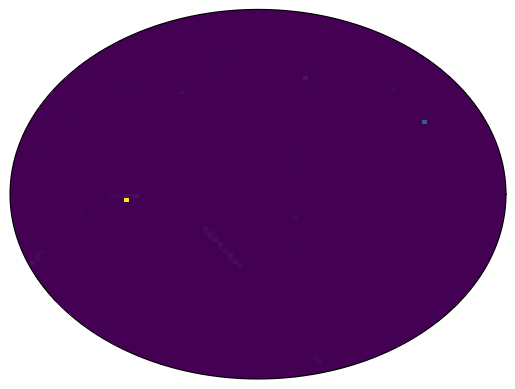

In [125]:
plot_2dhist(df_raw)

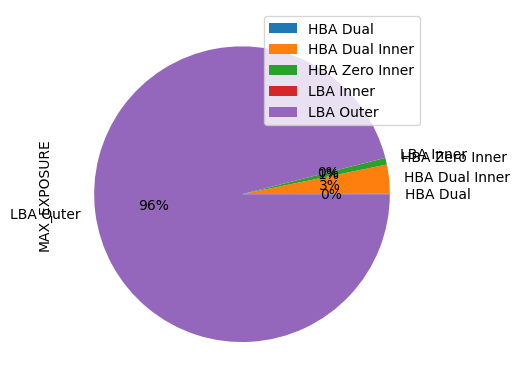

In [107]:
plot_pie(df_raw, 'ANTENNA_SET')

# TEST 

(20000, 2)
(40, 40)


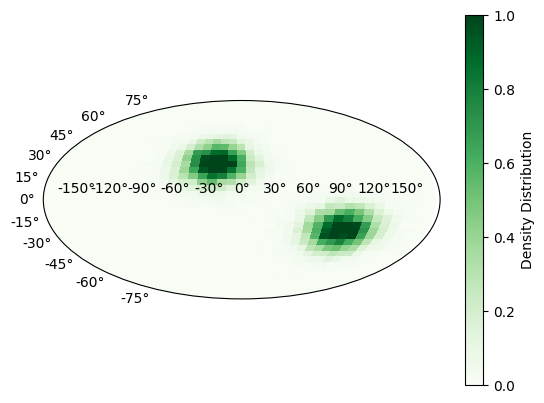

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# create some random data for histogram
base = [[-20, 30], [100, -20]]
data = []
for _ in range(10000):
    data.append((
        base[0][0] + np.random.normal(0, 20),
        base[0][1] + np.random.normal(0, 10)
    ))
    data.append((
        base[1][0] + np.random.normal(0, 20),
        base[1][1] + np.random.normal(0, 10)
    ))
data = np.array(data) / 180 * np.pi  # shape (n, 2)
print(data.shape)
# create bin edges
bin_number = 40
lon_edges = np.linspace(-np.pi, np.pi, bin_number + 1)
lat_edges = np.linspace(-np.pi/2., np.pi/2., bin_number + 1)

# calculate 2D histogram, the shape of hist is (bin_number, bin_number)
hist, lon_edges, lat_edges = np.histogram2d(
    *data.T, bins=[lon_edges, lat_edges], density=True
)

# generate the plot
cmap = plt.cm.Greens

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

ax.pcolor(
    lon_edges[:-1], lat_edges[:-1],
    hist.T,  # transpose from (row, column) to (x, y)
    cmap=cmap, shading='auto',
    vmin=0, vmax=1
)

# hide the tick labels
# ax.set_xticks([])
# ax.set_yticks([])

# add the colorbar
cbar = plt.colorbar(
        plt.cm.ScalarMappable(
            norm=mpl.colors.Normalize(0, 1), cmap=cmap
        )
    )
cbar.set_label("Density Distribution")
print(hist.shape)
plt.show()